# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of model goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and validation (val) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you should select your final/best model and hyperparameters to run one time only and then make the business performance tables for that final model. Note once we've decided on the final model and hyperparameters we're allowed to make several trial runs of our final model train looking for a good performance on the testing data, as long as we don't make any changes to the model hyperparameters from our final choice.

Things to add: better calculation of DR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [3]:
# Some names and parameters
in_file = 'vars_final (3).csv' # name of the modeling data file
y_name = 'fraud_label' # name of the dependent variable field
record = 'record' # name for the record number field
NVARS  = 10 # how many independent variables you want to keep. Less than or equal to the # in the file
val_record = 1000 # if you want, break out some of the last records for a validation data set.
# The validation data should generally be selected randomly, but here we're doing out of time validation
nitermax = 5 # this is the number of cross validation train/tests to do for each model build

In [4]:
%%time
vars = pd.read_csv(in_file)
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: user 373 ms, sys: 58.1 ms, total: 431 ms
Wall time: 430 ms


,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since,...,address_count_14,fulladdress_count_14,max_count_by_address_1,max_count_by_fulladdress_1,address_count_7,fulladdress_count_7,address_unique_count_for_name_homephone_60,address_count_0_by_30,record,fraud_label
0,1,1,5,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,1,0
1,1,1,6,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,2,1
2,1,1,4,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,3,0
3,1,1,4,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,4,0
4,1,1,4,1,1,30.0,365.0,1,365.0,365.0,...,1,1,1,1,1,1,1,30.0,5,0


In [5]:
num_bad = vars[y_name].sum()
num_good = len(vars) - num_bad
detect_rate = 2 * num_bad / len(vars)
numvars = min(NVARS,len(vars)-2)
print(vars.shape, num_good,num_bad,detect_rate,numvars)
final_vars_list = [record,y_name]
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

(1000000, 22) 985607 14393 0.028786 10


['record',
 'fraud_label',
 'max_count_by_address_30',
 'max_count_by_ssn_7',
 'max_count_by_homephone_7',
 'zip5_unique_count_for_dob_1',
 'max_count_by_fulladdress_30',
 'fulladdress_count_0_by_30',
 'ssn_day_since',
 'max_count_by_address_7',
 'address_day_since',
 'fulladdress_day_since']

In [6]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,record,fraud_label,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since
0,1,0,1,1,5,1,1,30.0,365.0,1,365.0,365.0
1,2,1,1,1,6,1,1,30.0,365.0,1,365.0,365.0
2,3,0,1,1,4,1,1,30.0,365.0,1,365.0,365.0
3,4,0,1,1,4,1,1,30.0,365.0,1,365.0,365.0
4,5,0,1,1,4,1,1,30.0,365.0,1,365.0,365.0


In [7]:
vars.shape

(1000000, 12)

In [8]:
vars[y_name].sum()

14393

In [9]:
print("y_name rate in data is",vars[y_name].sum()/len(vars))

y_name rate in data is 0.014393


In [10]:
vars.head(10)

,record,fraud_label,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since
0,1,0,1,1,5,1,1,30.0,365.0,1,365.0,365.0
1,2,1,1,1,6,1,1,30.0,365.0,1,365.0,365.0
2,3,0,1,1,4,1,1,30.0,365.0,1,365.0,365.0
3,4,0,1,1,4,1,1,30.0,365.0,1,365.0,365.0
4,5,0,1,1,4,1,1,30.0,365.0,1,365.0,365.0
5,6,0,1,1,5,1,1,30.0,365.0,1,365.0,365.0
6,7,0,1,1,4,1,1,30.0,365.0,1,365.0,365.0
7,8,0,1,1,2,1,1,30.0,365.0,1,365.0,365.0
8,9,0,1,1,5,1,1,30.0,365.0,1,365.0,365.0
9,10,0,1,1,5,1,1,30.0,365.0,1,365.0,365.0


In [11]:
vars.shape

(1000000, 12)

In [12]:
vars.describe()

,record,fraud_label,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,1.179185,1.059005,4.361851,1.512163,1.143258,29.489603,327.065515,1.101238,320.117207,325.060480
std,288675.278932,0.119104,1.152676,0.779273,2.226316,0.964281,1.080993,2.834776,96.703231,1.019993,104.836655,99.097485
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.304348,0.000000,1.000000,0.000000,0.000000
25%,250000.750000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000
50%,500000.500000,0.000000,1.000000,1.000000,4.000000,1.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000
75%,750000.250000,0.000000,1.000000,1.000000,5.000000,2.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000
max,1000000.000000,1.000000,30.000000,34.000000,33.000000,33.000000,30.000000,30.000000,365.000000,30.000000,365.000000,365.000000


In [13]:
# select the records that will become the validation data
validation = vars[vars[record] > val_record]
validation.head(10)

,record,fraud_label,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since
833507,833508,0,1,1,5,1,1,30.0,124.0,1,124.0,124.0
833508,833509,0,1,1,1,1,1,30.0,365.0,1,365.0,365.0
833509,833510,0,2,1,5,1,2,15.0,9.0,1,9.0,9.0
833510,833511,0,1,1,2,1,1,30.0,365.0,1,365.0,365.0
833511,833512,0,1,1,3,2,1,30.0,365.0,1,365.0,365.0
833512,833513,0,2,2,3,1,2,15.0,4.0,2,4.0,4.0
833513,833514,0,1,1,5,1,1,30.0,365.0,1,365.0,365.0
833514,833515,0,1,1,5,1,1,30.0,365.0,1,365.0,365.0
833515,833516,0,1,1,3,1,1,30.0,286.0,1,286.0,286.0
833516,833517,0,1,1,5,1,1,30.0,365.0,1,365.0,365.0


In [14]:
record_save = vars[record]
Y_save = pd.DataFrame(vars.loc[:,y_name])
Y_save.head()

,fraud_label
0,0
1,1
2,0
3,0
4,0


## Scale and truncate field values

In [15]:
X_no_scaling = vars.drop(columns = [record,y_name])
X_no_scaling.describe()

,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.179185,1.059005,4.361851,1.512163,1.143258,29.489603,327.065515,1.101238,320.117207,325.060480
std,1.152676,0.779273,2.226316,0.964281,1.080993,2.834776,96.703231,1.019993,104.836655,99.097485
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.304348,0.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,3.000000,1.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000
50%,1.000000,1.000000,4.000000,1.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000
75%,1.000000,1.000000,5.000000,2.000000,1.000000,30.000000,365.000000,1.000000,365.000000,365.000000
max,30.000000,34.000000,33.000000,33.000000,30.000000,30.000000,365.000000,30.000000,365.000000,365.000000


In [16]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [17]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [18]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,7.652545e-18,-9.137580e-18,1.791989e-17,-1.255671e-16,1.450218e-17,-5.438849e-17,-5.240963e-17,-2.327916e-17,6.406253e-17,-2.775380e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.820282e-01,-9.940138e-02,-1.520183e+00,-5.705647e-01,-1.604064e-01,-9.942674e+00,-3.382157e+00,-1.188280e-01,-3.053486e+00,-3.280209e+00
25%,-1.820282e-01,-9.940138e-02,-6.154198e-01,-5.705647e-01,-1.604064e-01,1.800485e-01,3.922773e-01,-1.188280e-01,4.281212e-01,4.030326e-01
50%,-1.820282e-01,-9.940138e-02,-1.630385e-01,-5.705647e-01,-1.604064e-01,1.800485e-01,3.922773e-01,-1.188280e-01,4.281212e-01,4.030326e-01
75%,-1.820282e-01,-9.940138e-02,2.893429e-01,5.544847e-01,-1.604064e-01,1.800485e-01,3.922773e-01,-1.188280e-01,4.281212e-01,4.030326e-01
max,1.296144e+01,1.779291e+01,1.007209e+01,1.085428e+01,1.391674e+01,1.800485e-01,3.922773e-01,1.470606e+01,4.281212e-01,4.030326e-01


In [19]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this val record number to whatever is appropriate for your data
X_trntst = X[0:val_record]
Y_trntst = Y_save[0:val_record]
X_val = X[val_record:]
Y_val = Y_save[val_record:]
Y_val.sum()

fraud_label    2386
dtype: int64

## Look at PCA

In [20]:
len(X_trntst.columns)

10

In [21]:
X_trntst_save = X_trntst.copy()

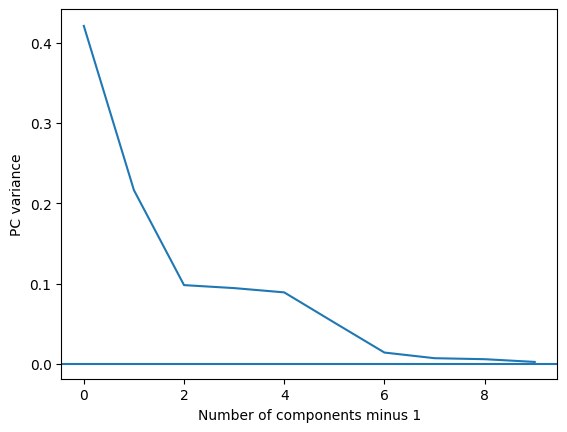

In [22]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [23]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-0.695055,0.246219,0.093017,0.228202
1,-0.645155,0.311354,0.157083,0.661100
2,-0.744956,0.181084,0.028951,-0.204696
3,-0.744956,0.181084,0.028951,-0.204696
4,-0.744956,0.181084,0.028951,-0.204696


In [24]:
princ_comps = pca.transform(X_val)
X_val_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_val.index)
X_val_orig_pca.head()

,PC1,PC2,PC3,PC4
833507,1.787667,-2.775973,-0.394029,0.610228
833508,-0.894656,-0.014320,-0.163246,-1.503389
833509,5.861722,-3.927055,-0.813828,0.014734
833510,-0.844756,0.050815,-0.099180,-1.070491
833511,-0.640979,0.365032,-0.162128,-0.496801


In [25]:
X_trntst.describe()

,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.002161,-0.001128,-0.000318,-0.000569,0.002509,0.000686,0.031901,0.001607,0.031615,0.031522
std,1.006457,0.989197,0.999109,1.002975,1.008758,0.998151,0.979454,1.010591,0.983233,0.981263
min,-0.182028,-0.099401,-1.520183,-0.570565,-0.160406,-9.942674,-3.382157,-0.118828,-3.053486,-3.280209
25%,-0.182028,-0.099401,-0.615420,-0.570565,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033
50%,-0.182028,-0.099401,-0.163038,-0.570565,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033
75%,-0.182028,-0.099401,0.289343,0.554485,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033
max,12.961438,17.792912,10.072093,10.854276,13.916738,0.180049,0.392277,14.706061,0.428121,0.403033


In [26]:
X_val_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.184289,-0.251306,-0.033866,0.035272
std,2.037060,1.526456,1.046470,0.975808
min,-0.894656,-5.874466,-2.014757,-6.283195
25%,-0.744956,-0.288000,-0.235792,-0.479085
50%,-0.591078,0.181084,-0.035114,0.076539
75%,0.282962,0.376489,0.043306,0.451711
max,25.140670,16.667044,17.942745,11.019368


In [27]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_val_orig_pca = (X_val_orig_pca - mean)/stdev

In [28]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,1.336679e-17,5.455831e-17,1.166184e-17,8.115549e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.378141e-01,-4.063495e+00,-2.193043e+00,-7.806064e+00
25%,-3.645557e-01,7.913792e-02,-1.654616e-01,-5.133624e-01
50%,-3.157168e-01,1.680495e-01,-3.445824e-02,-6.603332e-02
75%,-2.139512e-01,2.935971e-01,9.427968e-02,3.812957e-01
max,1.242679e+01,1.159004e+01,1.906309e+01,1.074410e+01


In [29]:
X_val_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.090185,-0.171521,-0.034325,0.036448
std,0.996867,1.041836,1.060675,1.008337
min,-0.437814,-4.009438,-2.042105,-6.492652
25%,-0.364556,-0.196565,-0.238992,-0.495056
50%,-0.289253,0.123594,-0.035591,0.079091
75%,0.138472,0.256961,0.043894,0.466770
max,12.302983,11.375584,18.186300,11.386711


In [30]:
X_trntst_pca.shape

(833507, 4)

In [31]:
X_val_orig_pca.shape

(166493, 4)

## Subsample the larger class if desired

In [32]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp[y_name] = Y_trntst[y_name]
temp.head()
goods = temp[temp[y_name]==0]
bads = temp[temp[y_name]==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled[y_name])
X_trntst_sampled = all_sampled.drop(columns=[y_name])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 10) 23841


In [33]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
jittersize = .1
X_val_orig = X_val.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [34]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','val'],index=range(1000))
counter = 0
model_counter = 0

In [35]:
%%time
# Logistic regression

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty='l2', C=0.2, solver='lbfgs', max_iter=300)

 
    X_val = X_val_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn[y_name] = Y_trn_save[y_name]
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst[y_name] = Y_tst[y_name]
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val[y_name] = Y_val[y_name]
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = ['log reg',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.5812883435582822 0.5879354290569244 0.5519698239731768
1 0.5862438908093932 0.5854063018242123 0.5519698239731768
2 0.5847792269953332 0.5882191780821918 0.5519698239731768
3 0.5921068320019077 0.5704419889502762 0.5519698239731768
4 0.5837217640731445 0.5917582417582418 0.5532271584241408
trn    0.585628
tst    0.584752
val    0.552221
dtype: float64
CPU times: user 48.9 s, sys: 5.46 s, total: 54.3 s
Wall time: 7.73 s


In [36]:
%%time
# Single DT

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    min_split = 90
    model = DecisionTreeClassifier(max_depth=5, min_samples_split=12, min_samples_leaf=5)
 
    X_val = X_val_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn[y_name] = Y_trn_save[y_name]
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst[y_name] = Y_tst[y_name]
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val[y_name] = Y_val[y_name]
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = ['DT',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1

print(DR.mean())
model_counter = model_counter + 1

0 0.6112632456244791 0.6274944567627494 0.5829840737636212
1 0.6176927674835625 0.6101043382756727 0.5804694048616932
2 0.6138660958496849 0.6236798221234019 0.5817267393126572
3 0.6140518580475565 0.6165475536008796 0.5804694048616932
4 0.6189416998361039 0.6066378066378066 0.5792120704107293
trn    0.615163
tst    0.616893
val    0.580972
dtype: float64
CPU times: user 2.95 s, sys: 382 ms, total: 3.33 s
Wall time: 2.86 s


In [37]:
%%time
# RF

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    min_split = 100
    model = RandomForestClassifier(n_estimators=40, max_depth=4, min_samples_split=10, min_samples_leaf=6)

    X_val = X_val_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn[y_name] = Y_trn_save[y_name]
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst[y_name] = Y_tst[y_name]
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val[y_name] = Y_val[y_name]
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = ['RF',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.616015207318522 0.6155988857938719 0.5838222967309304
1 0.6202090592334495 0.6055917480998915 0.585498742665549
2 0.6134866451071984 0.6186440677966102 0.5859178541492037
3 0.6181295653215184 0.6137855579868708 0.584241408214585
4 0.616998450351651 0.6116639027086789 0.5863369656328583
trn    0.616968
tst    0.613057
val    0.585163
dtype: float64
CPU times: user 31.3 s, sys: 808 ms, total: 32.1 s
Wall time: 32.4 s


In [38]:
%%time
# LGBM

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(n_estimators=60, max_depth=2, learning_rate=0.05, num_leaves=30)


    X_val = X_val_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn[y_name] = Y_trn_save[y_name]
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst[y_name] = Y_tst[y_name]
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val[y_name] = Y_val[y_name]
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter,'val'] = sum(needed)/sum(X_val.loc[:,y_name])
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = ['LGBM',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.6210426089026422 0.6169209431345354 0.5913663034367141
1 0.6203381700443699 0.6150490730643402 0.5909471919530596
2 0.6174089068825911 0.6201163757273483 0.5917854149203688
3 0.620730691419731 0.6176470588235294 0.5922045264040234
4 0.6212085308056872 0.6173254835996635 0.5922045264040234
trn    0.620146
tst    0.617412
val    0.591702
dtype: float64
CPU times: user 29.5 s, sys: 1.2 s, total: 30.7 s
Wall time: 6.44 s


In [41]:
%%time
# NN

DR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'val'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
      
    model = MLPClassifier(hidden_layer_sizes=(7,), learning_rate='constant', max_iter=300)

    X_val = X_val_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn[y_name] = Y_trn_save[y_name]
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst[y_name] = Y_tst[y_name]
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val[y_name] = Y_val[y_name]
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = ['NN',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
    
print(DR.mean())
model_counter = model_counter + 1

0 0.6155942647233085 0.6199551569506726 0.5859178541492037
1 0.62059588555214 0.6151028458720766 0.5884325230511316
2 0.6153754469606675 0.6248272048659109 0.5829840737636212
3 0.6195717191051561 0.6099232456140351 0.5863369656328583
4 0.6176891859632371 0.6216588591898594 0.5871751886001676
trn    0.617765
tst    0.618293
val    0.586169
dtype: float64
CPU times: user 45.5 s, sys: 3.3 s, total: 48.8 s
Wall time: 34.4 s


## Model comparison plots

In [51]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,val
0,log reg,0.581288,0.587935,0.55197
1,log reg,0.586244,0.585406,0.55197
2,log reg,0.584779,0.588219,0.55197
3,log reg,0.592107,0.570442,0.55197
4,log reg,0.583722,0.591758,0.553227
5,DT,0.611263,0.627494,0.582984
6,DT,0.617693,0.610104,0.580469
7,DT,0.613866,0.62368,0.581727
8,DT,0.614052,0.616548,0.580469
9,DT,0.618942,0.606638,0.579212


In [52]:
df.shape

(45, 4)

In [53]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','val'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.581288
1,log reg,Trn,0.586244
2,log reg,Trn,0.584779
3,log reg,Trn,0.592107
4,log reg,Trn,0.583722


In [54]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='val')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.581288
1,log reg,Trn,0.586244
2,log reg,Trn,0.584779
3,log reg,Trn,0.592107
4,log reg,Trn,0.583722


In [55]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'val':['mean','std']})
output

Trn                 Tst                 val          
                     mean       std      mean       std      mean       std
Model                                                                      
DT               0.615163  0.003115  0.616893  0.008801  0.580972  0.001434
LGBM             0.620146  0.001566  0.617412  0.001817  0.591702  0.000546
LGBM sampled     0.605597  0.004346  0.605597  0.004346  0.572171  0.004227
LGBM with SMOTE  0.615467  0.001963  0.615392  0.005606  0.585834  0.000859
NN               0.617765  0.002329  0.618293  0.005853  0.586169  0.002023
RF               0.616968  0.002494  0.613057  0.004896  0.585163  0.001085
XGB              0.616022  0.001033  0.605433  0.002967  0.581894  0.001470
cat boost        0.618535  0.002616  0.623021  0.002807  0.589858  0.001009
log reg          0.585628  0.004048  0.584752  0.008313  0.552221  0.000562

In [56]:
df.head()

,Model,Trn,Tst,val
0,log reg,0.581288,0.587935,0.55197
1,log reg,0.586244,0.585406,0.55197
2,log reg,0.584779,0.588219,0.55197
3,log reg,0.592107,0.570442,0.55197
4,log reg,0.583722,0.591758,0.553227


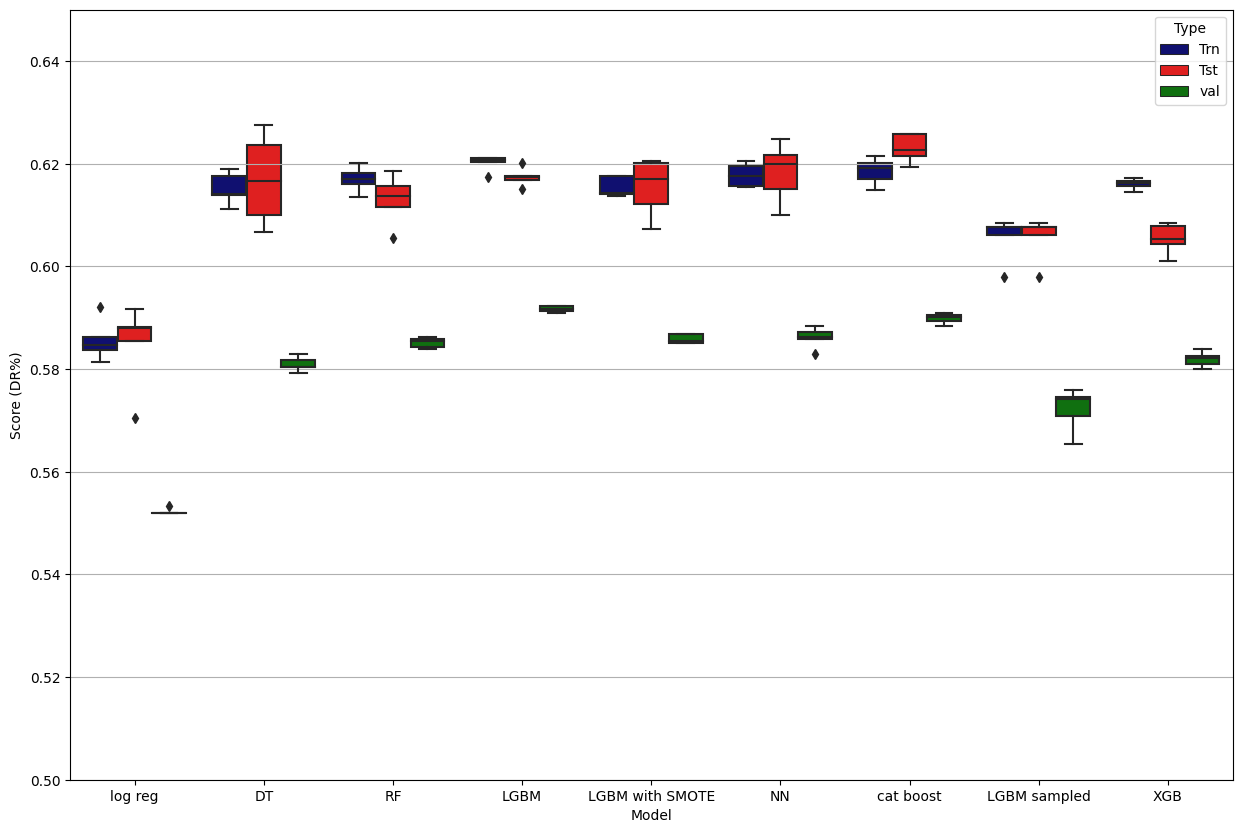

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.65)
plt.ylabel('Score (DR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [58]:
best_val = df['val'].max()
row = df.loc[df['val'] == best_val]
best_model = row['Model']
print(best_model, '\n', best_val)

18    LGBM
19    LGBM
Name: Model, dtype: object 
 0.5922045264040234


In [59]:
%%time
# Note - need to set this next value to around the highest val DR for your model of choice.
# The model then runs a nomber of times with your fixed hyperparameters until it finds a good model.

for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the val performance where I want to break out this loop
# and that will be my final model run of choice
    model = lgb.LGBMClassifier(n_estimators=60, max_depth=2, learning_rate=0.05, num_leaves=30)


    X_val = X_val_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn[y_name] = Y_trn_save[y_name]
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,y_name])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst[y_name] = Y_tst[y_name]
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,y_name])

    predictions = model.predict_proba(X_val)[:,1]
    X_val['predicted']=predictions
    X_val[y_name] = Y_val[y_name]
    topRows = int(round(X_val.shape[0]*detect_rate))
    temp = X_val.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,y_name]
    DR.loc[niter, 'val'] = sum(needed)/sum(X_val.loc[:,y_name])
    print(niter, DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val'])
    Modeling_output.iloc[counter] = ['LGBM',DR.loc[niter, 'trn'],DR.loc[niter, 'tst'],DR.loc[niter, 'val']]
    counter = counter + 1
# choose a good break point
    if(DR.loc[niter, 'val'] >= best_val): break
    
model_counter = model_counter + 1

0 0.6177446102819237 0.6255259467040674 0.5901089689857502
1 0.6195690568703638 0.6126920887877063 0.5905280804694049
2 0.6190589353612167 0.6215538847117794 0.5917854149203688
3 0.6211062418571598 0.6178451178451179 0.5909471919530596
4 0.6236316039980961 0.6103247293921732 0.5905280804694049
5 0.6198795180722891 0.6166711626652279 0.5901089689857502
6 0.6205048821147893 0.6173455250761984 0.5905280804694049
7 0.6197953842493457 0.6148292141071925 0.5926236378876781
CPU times: user 47.6 s, sys: 1.94 s, total: 49.5 s
Wall time: 10.4 s


In [60]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_val_eval = X_val.copy()

In [61]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','DR','KS','FPR']
DR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
DR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
DR_val = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
val_sorted = X_val_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, y_name])
bad_tot_tst = sum(X_tst_eval.loc[:, y_name])
bad_tot_val = sum(X_val_eval.loc[:, y_name])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_val = len(X_val_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_val = num_tot_val - bad_tot_val
val_sorted.head(20)

,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since,predicted,fraud_label
885088,12.961438,-0.099401,7.527444,10.854276,13.916738,-9.520894,0.392277,14.706061,-3.043947,-3.270118,0.997637,1
885388,12.961438,-0.099401,7.527444,10.854276,13.916738,-7.580705,-3.278748,14.706061,-3.053486,-3.280209,0.997093,1
915662,12.961438,-0.099401,10.072093,10.854276,13.916738,-7.146537,-3.040907,14.706061,-3.053486,-3.280209,0.997049,1
915263,12.961438,-0.099401,10.072093,10.854276,13.916738,-8.478644,-0.248859,14.706061,-3.053486,-3.280209,0.996997,1
915152,12.961438,-0.099401,10.072093,10.679929,13.916738,-9.344513,0.392277,14.706061,-3.043947,-3.270118,0.996951,1
881950,12.961438,-0.099401,10.072093,10.854276,13.916738,-1.744105,-2.585907,14.706061,-3.053486,-3.280209,0.996771,1
917269,12.961438,-0.099401,10.072093,10.854276,13.916738,-3.221581,-2.741020,14.706061,-3.053486,-3.280209,0.996771,1
994505,12.961438,-0.099401,8.432207,9.554880,13.916738,-9.226926,0.392277,14.706061,-3.043947,-3.270118,0.996661,1
915422,12.961438,-0.099401,10.072093,10.854276,13.916738,-7.757086,0.392277,14.706061,-3.053486,-3.280209,0.996646,1
994829,12.961438,-0.099401,8.432207,10.854276,13.916738,-6.875182,0.392277,14.706061,-3.053486,-3.280209,0.996646,1


In [62]:
cost_y_name = 4000
cost_fp = 100
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_val = int(round(X_val_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_val = val_sorted.head(percent_rows_val)
    num_bad_trn = sum(temp_trn.loc[:,y_name])
    num_bad_tst = sum(temp_tst.loc[:,y_name])
    num_bad_val = sum(temp_val.loc[:,y_name])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_val = len(temp_val)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_val = num_tot_val - num_bad_val
    
    DR_trn.loc[i, 'bin'] = i
    DR_trn.loc[i,'#recs'] = 0
    DR_trn.loc[i, 'tot'] = num_tot_trn
    DR_trn.loc[i, 'cg'] = num_good_trn
    DR_trn.loc[i, 'cb'] = num_bad_trn
    DR_trn.loc[i, 'y_name Savings'] = DR_trn.loc[i, 'cb'] * cost_y_name
    DR_trn.loc[i, 'FP Loss'] = DR_trn.loc[i, 'cg'] * cost_fp
    DR_trn.loc[i, 'Overall Savings'] = DR_trn.loc[i, 'y_name Savings'] - DR_trn.loc[i, 'FP Loss']
    DR_tst.loc[i, 'bin'] = i
    DR_tst.loc[i, 'tot'] = num_tot_tst
    DR_tst.loc[i, 'cg'] = num_good_tst
    DR_tst.loc[i, 'cb'] = num_bad_tst
    DR_tst.loc[i, 'y_name Savings'] = DR_tst.loc[i, 'cb'] * cost_y_name
    DR_tst.loc[i, 'FP Loss'] = DR_tst.loc[i, 'cg'] * cost_fp
    DR_tst.loc[i, 'Overall Savings'] = DR_tst.loc[i, 'y_name Savings'] - DR_tst.loc[i, 'FP Loss']
    DR_val.loc[i, 'bin'] = i
    DR_val.loc[i, 'tot'] = num_tot_val
    DR_val.loc[i, 'cg'] = num_good_val
    DR_val.loc[i, 'cb'] = num_bad_val

    if i != 0:
        DR_trn.loc[i, '#g'] = num_good_trn - DR_trn.loc[i-1, 'cg']
        DR_trn.loc[i, '#b'] = num_bad_trn - DR_trn.loc[i-1, 'cb']
        DR_trn.loc[i,'#recs'] = DR_trn.loc[i, '#g'] + DR_trn.loc[i, '#b']
        DR_trn.loc[i, '%g'] = 100* (num_good_trn - DR_trn.loc[i-1, 'cg']) / (num_tot_trn - DR_trn.loc[i-1, 'tot'])
        DR_trn.loc[i, '%b'] = 100 - DR_trn.loc[i, '%g']
        DR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        DR_trn.loc[i, 'DR'] = 100 * num_bad_trn / bad_tot_trn
        DR_trn.loc[i, 'KS'] = DR_trn.loc[i, 'DR'] - DR_trn.loc[i, '%cg']
        DR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        DR_tst.loc[i, '#g'] = num_good_tst - DR_tst.loc[i-1, 'cg']
        DR_tst.loc[i, '#b'] = num_bad_tst - DR_tst.loc[i-1, 'cb']
        DR_tst.loc[i,'#recs'] = DR_tst.loc[i, '#g'] + DR_tst.loc[i, '#b']
        DR_tst.loc[i, '%g'] = 100* (num_good_tst - DR_tst.loc[i-1, 'cg']) / (num_tot_tst - DR_tst.loc[i-1, 'tot'])
        DR_tst.loc[i, '%b'] = 100 - DR_tst.loc[i, '%g']
        DR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        DR_tst.loc[i, 'DR'] = 100 * num_bad_tst / bad_tot_tst
        DR_tst.loc[i, 'KS'] = DR_tst.loc[i, 'DR'] - DR_tst.loc[i, '%cg']
        DR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        DR_val.loc[i, '#g'] = num_good_val - DR_val.loc[i-1, 'cg']
        DR_val.loc[i, '#b'] = num_bad_val - DR_val.loc[i-1, 'cb']
        DR_val.loc[i,'#recs'] = DR_val.loc[i, '#g'] + DR_val.loc[i, '#b']
        DR_val.loc[i, '%g'] = 100* (num_good_val - DR_val.loc[i-1, 'cg']) / (num_tot_val - DR_val.loc[i-1, 'tot'])
        DR_val.loc[i, '%b'] = 100 - DR_val.loc[i, '%g']
        DR_val.loc[i, '%cg'] = 100 * num_good_val / good_tot_val
        DR_val.loc[i, 'DR'] = 100 * num_bad_val / bad_tot_val
        DR_val.loc[i, 'KS'] = DR_val.loc[i, 'DR'] - DR_val.loc[i, '%cg']
        DR_val.loc[i, 'FPR'] = num_good_val / num_bad_val

DR_val

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,DR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,433.0,1232.0,26.006006,73.993994,1665.0,433.0,1232.0,0.263852,51.634535,51.370683,0.351461
2,2.0,1665.0,1549.0,116.0,93.033033,6.966967,3330.0,1982.0,1348.0,1.207749,56.496228,55.288479,1.470326
3,3.0,1665.0,1598.0,67.0,95.975976,4.024024,4995.0,3580.0,1415.0,2.181504,59.304275,57.122771,2.530035
4,4.0,1665.0,1648.0,17.0,98.978979,1.021021,6660.0,5228.0,1432.0,3.185726,60.016764,56.831038,3.650838
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1660.0,5.0,99.699700,0.300300,159833.0,157489.0,2344.0,95.967265,98.239732,2.272467,67.188140
97,97.0,1665.0,1655.0,10.0,99.399399,0.600601,161498.0,159144.0,2354.0,96.975754,98.658843,1.683090,67.605777
98,98.0,1665.0,1654.0,11.0,99.339339,0.660661,163163.0,160798.0,2365.0,97.983633,99.119866,1.136233,67.990698
99,99.0,1665.0,1650.0,15.0,99.099099,0.900901,164828.0,162448.0,2380.0,98.989074,99.748533,0.759459,68.255462


Max possible savings: 3,181,200,000.0


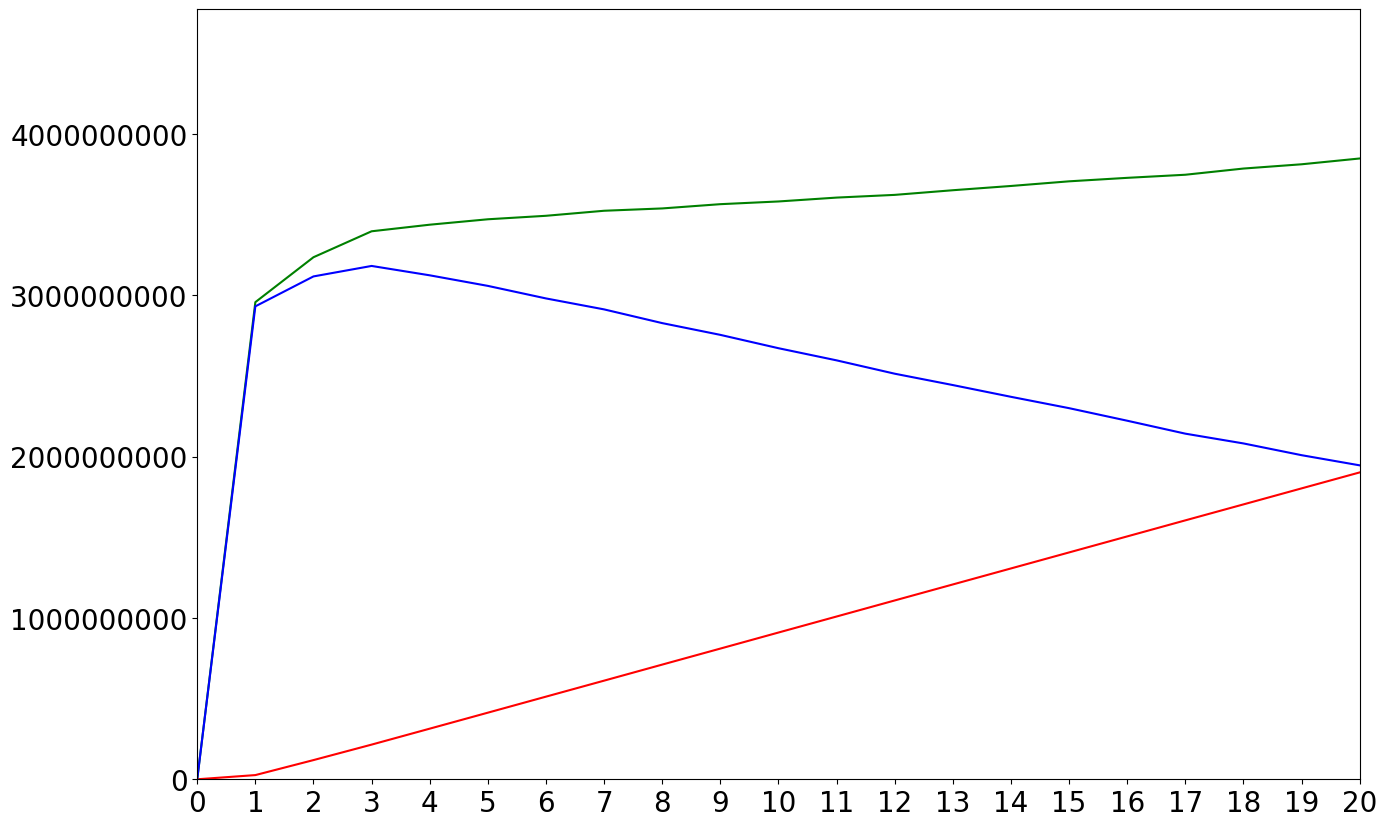

In [63]:
# xmult: val is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xval = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['y_name Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['y_name Savings','FP Loss','Overall Savings'])
Financials_val = pd.DataFrame(np.zeros((101, 3)), columns = ['y_name Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'y_name Savings'] = DR_trn.loc[i, 'cb'] * cost_y_name * xval
    Financials_trn.loc[i, 'FP Loss'] = DR_trn.loc[i, 'cg'] * cost_fp * xval
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'y_name Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'y_name Savings'] = DR_tst.loc[i, 'cb'] * cost_y_name * xval
    Financials_tst.loc[i, 'FP Loss'] = DR_tst.loc[i, 'cg'] * cost_fp * xval
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'y_name Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_val.loc[i, 'y_name Savings'] = DR_val.loc[i, 'cb'] * cost_y_name * xval
    Financials_val.loc[i, 'FP Loss'] = DR_val.loc[i, 'cg'] * cost_fp * xval
    Financials_val.loc[i, 'Overall Savings'] = Financials_val.loc[i, 'y_name Savings'] - Financials_val.loc[i, 'FP Loss']

max_savings = Financials_val['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_val['y_name Savings'], color='green')
plt.plot(Financials_val['FP Loss'], color='red')
plt.plot(Financials_val['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [64]:
DR_val.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,DR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,433.0,1232.0,26.006006,73.993994,1665.0,433.0,1232.0,0.263852,51.634535,51.370683,0.351461
2,2.0,1665.0,1549.0,116.0,93.033033,6.966967,3330.0,1982.0,1348.0,1.207749,56.496228,55.288479,1.470326
3,3.0,1665.0,1598.0,67.0,95.975976,4.024024,4995.0,3580.0,1415.0,2.181504,59.304275,57.122771,2.530035
4,4.0,1665.0,1648.0,17.0,98.978979,1.021021,6660.0,5228.0,1432.0,3.185726,60.016764,56.831038,3.650838
5,5.0,1665.0,1651.0,14.0,99.159159,0.840841,8325.0,6879.0,1446.0,4.191777,60.603521,56.411743,4.757261
6,6.0,1665.0,1656.0,9.0,99.459459,0.540541,9990.0,8535.0,1455.0,5.200875,60.980721,55.779846,5.865979
7,7.0,1665.0,1652.0,13.0,99.219219,0.780781,11655.0,10187.0,1468.0,6.207535,61.525566,55.318030,6.939373
8,8.0,1664.0,1658.0,6.0,99.639423,0.360577,13319.0,11845.0,1474.0,7.217852,61.777033,54.559181,8.035957
9,9.0,1665.0,1654.0,11.0,99.339339,0.660661,14984.0,13499.0,1485.0,8.225731,62.238055,54.012325,9.090236


In [65]:
DR.to_csv('DR.csv')

In [66]:
DR_trn.to_csv('DR_trn.csv', index=False)
DR_tst.to_csv('DR_tst.csv', index=False)
DR_val.to_csv('DR_val.csv', index=False)

In [67]:
Metrics = DR_val.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

164107.0 2386.0 166493.0 166493.0


In [68]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'DR')

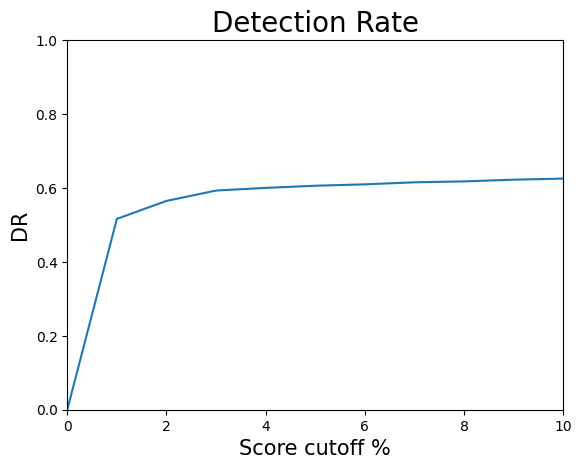

In [69]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('DR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the DR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

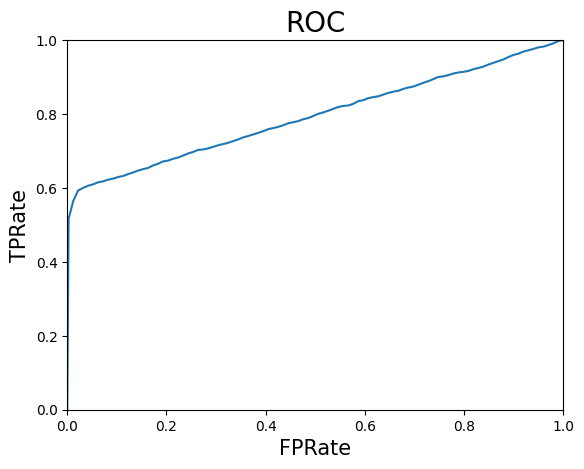

In [70]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

# Score Calibration

In [71]:
base = 600
delta = 20
odds_at_base = .1

In [72]:
df = pd.concat([X_trn_eval,X_tst_eval,X_val_eval])
df.shape

(1000000, 12)

In [73]:
df.head()

,max_count_by_address_30,max_count_by_ssn_7,max_count_by_homephone_7,zip5_unique_count_for_dob_1,max_count_by_fulladdress_30,fulladdress_count_0_by_30,ssn_day_since,max_count_by_address_7,address_day_since,fulladdress_day_since,predicted,fraud_label
765598,-0.182028,-0.099401,-0.615420,-0.570565,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033,0.005296,0
388423,-0.182028,-0.099401,0.289343,0.554485,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033,0.005788,0
415127,-0.182028,-0.099401,0.289343,0.554485,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033,0.005788,0
384655,-0.182028,-0.099401,-1.067801,-0.570565,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033,0.005296,0
621534,-0.182028,-0.099401,-0.163038,-0.570565,-0.160406,0.180049,0.392277,-0.118828,0.428121,0.403033,0.005296,0


In [74]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

,score_raw,fraud_label
892206,0.002776,0
404514,0.002952,0
786044,0.003058,0
768500,0.003058,0
933375,0.003058,0


In [75]:
calib.shape

(1000000, 2)

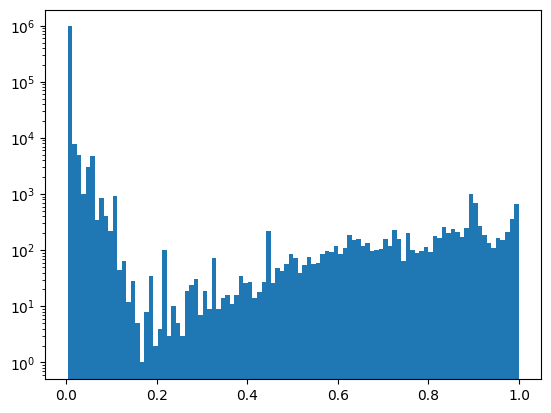

In [76]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [77]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=1000
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [78]:
bad_tot = sum(calib.loc[:, y_name])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

14393 985607


In [79]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,y_name]))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, y_name]))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,1000.0,993.0,7.0,99.3,0.7,1000.0,993.0,7.0,0.004181,0.7,0.007050,-7.148089,-7.148089
2,2.0,1000.0,997.0,3.0,99.7,0.3,2000.0,1990.0,10.0,0.004278,0.3,0.003010,-8.376006,-7.148089
3,3.0,1000.0,997.0,3.0,99.7,0.3,3000.0,2987.0,13.0,0.004390,0.3,0.003010,-8.376006,-7.148089
4,4.0,1000.0,999.0,1.0,99.9,0.1,4000.0,3986.0,14.0,0.004432,0.1,0.001002,-9.962899,-7.148089
5,5.0,1000.0,997.0,3.0,99.7,0.3,5000.0,4983.0,17.0,0.004432,0.3,0.003010,-8.376006,-7.148089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996.0,1000.0,133.0,867.0,13.3,86.7,996000.0,985350.0,10650.0,0.865306,86.7,6.518805,2.704607,2.704607
997,997.0,1000.0,105.0,895.0,10.5,89.5,997000.0,985455.0,11545.0,0.893754,89.5,8.523819,3.091500,3.091500
998,998.0,1000.0,80.0,920.0,8.0,92.0,998000.0,985535.0,12465.0,0.905003,92.0,11.500013,3.523564,3.523564
999,999.0,1000.0,61.0,939.0,6.1,93.9,999000.0,985596.0,13404.0,0.951005,93.9,15.393459,3.944246,3.944246


In [80]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
996,996.0,1000.0,133.0,867.0,13.3,86.7,996000.0,985350.0,10650.0,0.865306,86.7,6.518805,2.704607,2.704607
997,997.0,1000.0,105.0,895.0,10.5,89.5,997000.0,985455.0,11545.0,0.893754,89.5,8.523819,3.091500,3.091500
998,998.0,1000.0,80.0,920.0,8.0,92.0,998000.0,985535.0,12465.0,0.905003,92.0,11.500013,3.523564,3.523564
999,999.0,1000.0,61.0,939.0,6.1,93.9,999000.0,985596.0,13404.0,0.951005,93.9,15.393459,3.944246,3.944246
1000,1000.0,1000.0,11.0,989.0,1.1,98.9,1000000.0,985607.0,14393.0,0.990955,98.9,89.909182,6.490397,6.490397


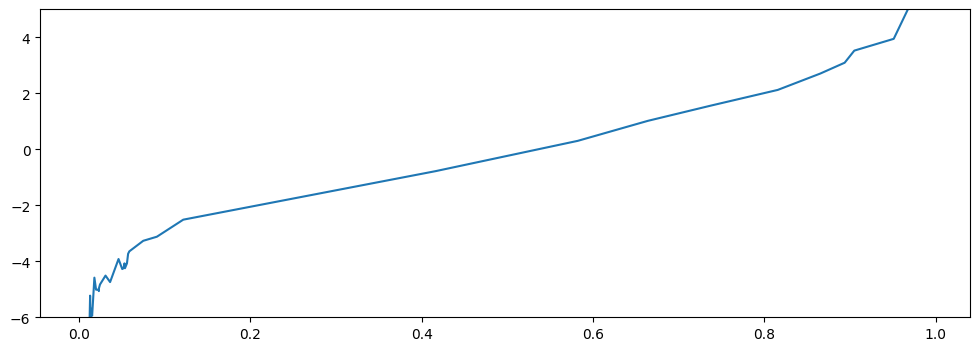

In [81]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [82]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [83]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.71373483  1.00375795 -0.00522644]


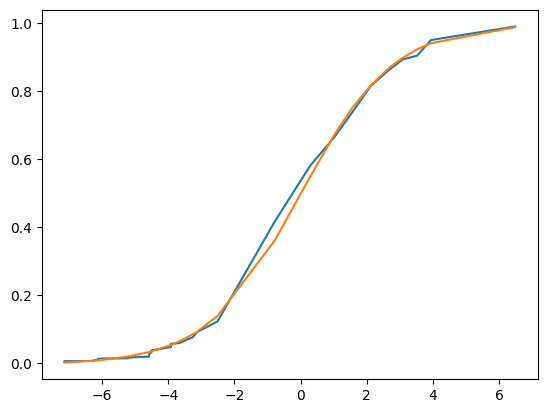

In [84]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

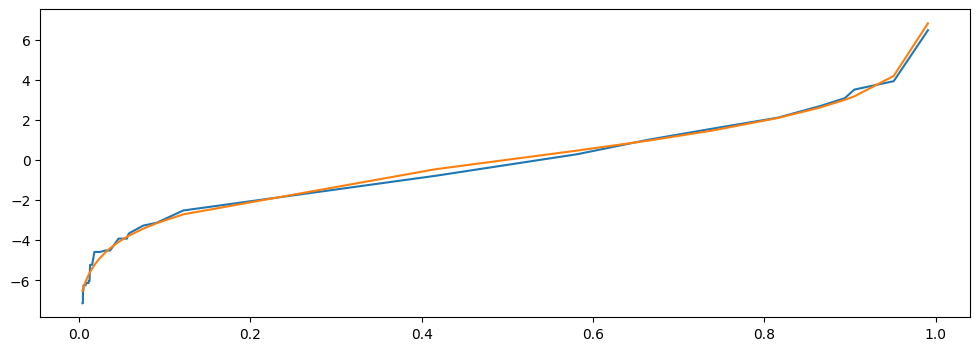

In [85]:
# look at the smvalh curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [86]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,1000.0,993.0,7.0,99.3,0.7,1000.0,993.0,7.0,0.004181,0.7,0.007050,-7.148089,-7.148089,-6.529805
2,2.0,1000.0,997.0,3.0,99.7,0.3,2000.0,1990.0,10.0,0.004278,0.3,0.003010,-8.376006,-7.148089,-6.515311
3,3.0,1000.0,997.0,3.0,99.7,0.3,3000.0,2987.0,13.0,0.004390,0.3,0.003010,-8.376006,-7.148089,-6.498842
4,4.0,1000.0,999.0,1.0,99.9,0.1,4000.0,3986.0,14.0,0.004432,0.1,0.001002,-9.962899,-7.148089,-6.492639
5,5.0,1000.0,997.0,3.0,99.7,0.3,5000.0,4983.0,17.0,0.004432,0.3,0.003010,-8.376006,-7.148089,-6.492639
6,6.0,1000.0,995.0,5.0,99.5,0.5,6000.0,5978.0,22.0,0.004432,0.5,0.005026,-7.636336,-7.148089,-6.492639
7,7.0,1000.0,994.0,6.0,99.4,0.6,7000.0,6972.0,28.0,0.004453,0.6,0.006037,-7.371899,-7.148089,-6.489599
8,8.0,1000.0,993.0,7.0,99.3,0.7,8000.0,7965.0,35.0,0.004483,0.7,0.007050,-7.148089,-7.148089,-6.485173
9,9.0,1000.0,994.0,6.0,99.4,0.6,9000.0,8959.0,41.0,0.004487,0.6,0.006037,-7.371899,-7.148089,-6.484536
10,10.0,1000.0,993.0,7.0,99.3,0.7,10000.0,9952.0,48.0,0.004487,0.7,0.007050,-7.148089,-7.148089,-6.484536


In [87]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [88]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
971,971.0,1000.0,984.0,16.0,98.4,1.6,971000.0,965451.0,5549.0,0.015447,1.6,0.016261,-5.942424,-5.227283,-5.410732,558.223931
972,972.0,1000.0,960.0,40.0,96.0,4.0,972000.0,966411.0,5589.0,0.018062,4.0,0.041668,-4.584926,-4.584926,-5.240144,561.635675
973,973.0,1000.0,970.0,30.0,97.0,3.0,973000.0,967381.0,5619.0,0.020028,3.0,0.030929,-5.014902,-4.584926,-5.123788,563.962801
974,974.0,1000.0,970.0,30.0,97.0,3.0,974000.0,968351.0,5649.0,0.023097,3.0,0.030929,-5.014902,-4.584926,-4.958710,567.264353
975,975.0,1000.0,971.0,29.0,97.1,2.9,975000.0,969322.0,5678.0,0.023333,2.9,0.029867,-5.065297,-4.584926,-4.946716,567.504236
976,976.0,1000.0,969.0,31.0,96.9,3.1,976000.0,970291.0,5709.0,0.023352,3.1,0.031993,-4.966110,-4.584926,-4.945763,567.523311
977,977.0,1000.0,966.0,34.0,96.6,3.4,977000.0,971257.0,5743.0,0.024618,3.4,0.035198,-4.828374,-4.584926,-4.883204,568.774474
978,978.0,1000.0,958.0,42.0,95.8,4.2,978000.0,972215.0,5785.0,0.031046,4.2,0.043842,-4.511530,-4.511530,-4.600643,574.425694
979,979.0,1000.0,964.0,36.0,96.4,3.6,979000.0,973179.0,5821.0,0.036394,3.6,0.037345,-4.742924,-4.511530,-4.400172,578.435129
980,980.0,1000.0,938.0,62.0,93.8,6.2,980000.0,974117.0,5883.0,0.046242,6.2,0.066099,-3.919225,-3.919225,-4.088211,584.674343


In [89]:
calib.head()

,score_raw,fraud_label
892206,0.002776,0
404514,0.002952,0
786044,0.003058,0
768500,0.003058,0
933375,0.003058,0


In [90]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

,score_raw,fraud_label,score_calib
892206,0.002776,0,676.381555
404514,0.002952,0,676.382187
786044,0.003058,0,676.382567
768500,0.003058,0,676.382567
933375,0.003058,0,676.382567


In [91]:
calib.tail()

,score_raw,fraud_label,score_calib
463882,0.998599,1,679.804569
463826,0.998599,1,679.804569
288416,0.998599,1,679.804569
548721,0.998767,1,679.805101
677406,0.999000,1,679.805837


In [92]:
calib.describe()

,score_raw,fraud_label,score_calib
count,1000000.000000,1000000.000000,1000000.000000
mean,0.014300,0.014393,676.422038
std,0.079449,0.119104,0.276015
min,0.002776,0.000000,676.381555
25%,0.005296,0.000000,676.390584
50%,0.005296,0.000000,676.390584
75%,0.005788,0.000000,676.392345
max,0.999000,1.000000,679.805837


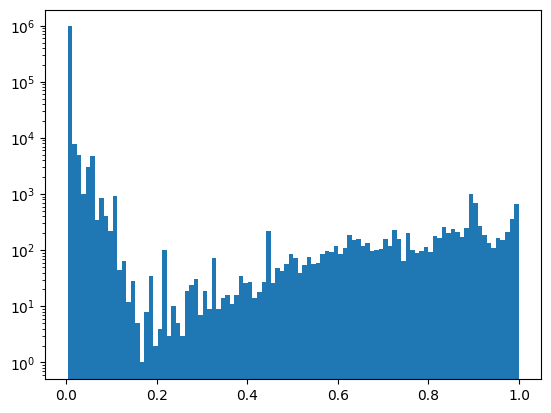

In [93]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

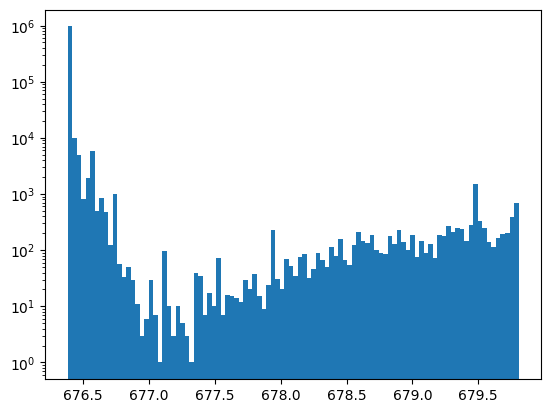

In [94]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

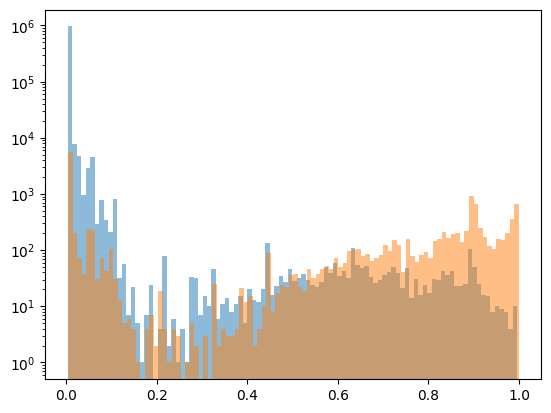

In [95]:
goods = calib[calib[y_name]==0]
bads = calib[calib[y_name]==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

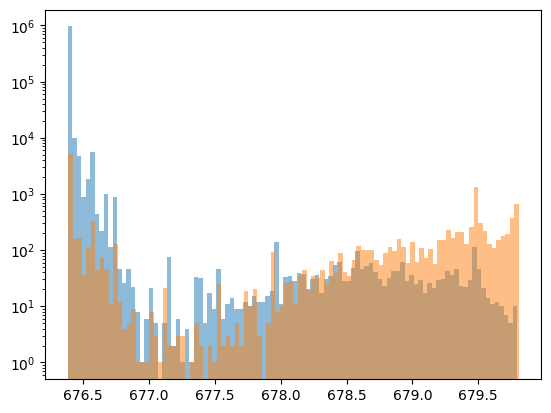

In [96]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [97]:
# scaling, and in particular calibration, doesn't change the KS
KS_raw = sps.ks_2samp(goods['score_raw'],bads['score_raw'])
KS_calib = sps.ks_2samp(goods['score_calib'],bads['score_calib'])
print(KS_raw)
print(KS_calib)

KstestResult(statistic=0.5954784720124358, pvalue=0.0)
KstestResult(statistic=0.5954784720124358, pvalue=0.0)


In [98]:
print("duration: ", datetime.now() - start_time)

duration:  0:02:10.943172


In [99]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/applications/give to usc'